# **Transforming the Rocket Transform**

## **Initialisation**

In [1]:
pip install sktime==0.31.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 12.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pickle
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import Input, Layer, Conv1D, MaxPool1D, ReLU, BatchNormalization, LayerNormalization, Dropout, Add, Dense, GlobalMaxPooling1D, Bidirectional, GRU

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/experiments')

%run ../sys_configs.ipynb

Mounted at /content/drive


In [5]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [6]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.float32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.float32)

In [7]:
C = len(set(y_train)) # Number of classes

#### **Prepare Rocket transformation train & validation datasets**

In [8]:
# Transpose the train and validation data as the format needs to be N x D x T
x_train_ = x_train.transpose((0, 2, 1))
x_val_ = x_val.transpose((0, 2, 1))

# Compute the MiniRocket transform and transform to tensors
minirocket_multi = MiniRocketMultivariate(num_kernels = 10000, max_dilations_per_kernel = 32)
minirocket_multi.fit(x_train_)

train_rocket_np = minirocket_multi.transform(x_train_).to_numpy()
val_rocket_np = minirocket_multi.transform(x_val_).to_numpy()

train_rocket_tf = tf.convert_to_tensor(train_rocket_np, dtype = tf.float32)
val_rocket_tf = tf.convert_to_tensor(val_rocket_np, dtype = tf.float32)


In [9]:
train_rocket_ds = tf.data.Dataset.from_tensor_slices((train_rocket_tf, train_labels_tf))
val_rocket_ds = tf.data.Dataset.from_tensor_slices((val_rocket_tf, val_labels_tf))

train_rocket_ds = train_rocket_ds.shuffle(500)

train_rocket_ds = train_rocket_ds.padded_batch(64)
val_rocket_ds = val_rocket_ds.padded_batch(64)

#### **Prepare PCA transformation train & validation datasets**

In this section, we show that it is possible to condense the 9,996 MiniRocket features into a compact representation while still preserving most of the information among those features. To understand why this is necessary, please open the workbook `Exploring Rocket Losses`. With the full 9,996 features, a feedforward neural network was able to perfectly recover the targets. Whilst this gave a good performance on the validation data, it was not compact.

Principle Components Analysis allows the user to construct this more compact representation and to quantify the variance in the original data which has been preserved.

In [10]:
pca = PCA(n_components=128)
pca.fit(train_rocket_np)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

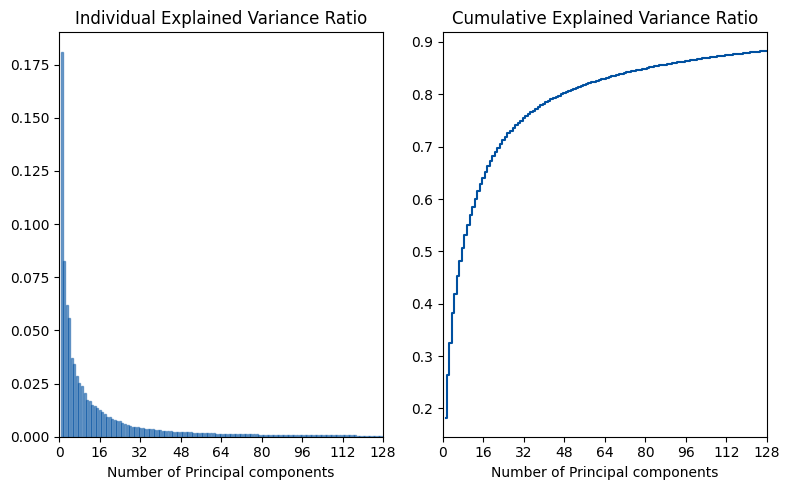

In [31]:
# Plot the explained variance ratio and cumulative explained variance as subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Plot individual explained variance ratio
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', color = "#0050a0", edgecolor = "#0050a0")
ax1.set_xlabel('Number of Principal components')
ax1.set_title('Individual Explained Variance Ratio')
ax1.set_xticks(range(0, 129, 16))  # Adjust the step size (16) as needed
ax1.set_xlim(0, 128)

# Plot cumulative explained variance
ax2.step(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, where='mid', color = "#0050a0")
ax2.set_xlabel('Number of Principal components')
ax2.set_title('Cumulative Explained Variance Ratio')
ax2.set_xticks(range(0, 129, 16))  # Adjust the step size (16) as needed
ax2.set_xlim(0, 128)

plt.tight_layout()
plt.savefig("PCA.pdf", dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()

Using the top 128 principle components preserves approx 90% of the variance of the original data (approx 1/40th of the original number of features), though the elbow point is around the top 32 principle components.

In [13]:
print(f"Proportion of variance that is preserved with 128 principle components: {np.cumsum(pca.explained_variance_ratio_)[127]}")

Proportion of variance that is preserved with 128 principle components: 0.883250892162323


In [14]:
train_pca_np = pca.transform(train_rocket_np)
val_pca_np = pca.transform(val_rocket_np)

In [15]:
train_pca_tf = tf.convert_to_tensor(train_pca_np, dtype = tf.float32)
val_pca_tf = tf.convert_to_tensor(val_pca_np, dtype = tf.float32)

In [16]:
train_pca_ds = tf.data.Dataset.from_tensor_slices((train_pca_tf, train_labels_tf))
val_pca_ds = tf.data.Dataset.from_tensor_slices((val_pca_tf, val_labels_tf))

train_pca_ds = train_pca_ds.shuffle(500)

train_pca_ds = train_pca_ds.padded_batch(64)
val_pca_ds = val_pca_ds.padded_batch(64)

## **Experiment: Rocket transformation with feedforward layers and L2 penalties**

In [17]:
def RocketSktimeL2(shape):
    block1_input_layer = Input(shape=shape)
    layer = Dense(128, activation="sigmoid", kernel_regularizer = l2(0.01))(block1_input_layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [18]:
rocketsktimeL2 = RocketSktimeL2(shape = (9996,))
rocketsktimeL2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9996)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,279,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,615 (4.90 MB)

 Trainable params: 1,283,615 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
rocketsktime_modelL2 = RocketSktimeL2(shape = (9996,))
rocketsktime_modelL2.compile(optimizer=Adam(learning_rate=1.0, beta_1=0.99, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_sktimeL2 = rocketsktime_modelL2.fit(train_rocket_ds,  validation_data = val_rocket_ds, epochs=10, verbose = 1)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0347 - loss: 3618.9587 - val_accuracy: 0.0295 - val_loss: 3756.0283
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0391 - loss: 3621.0718 - val_accuracy: 0.0445 - val_loss: 2864.6770
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0384 - loss: 3453.9260 - val_accuracy: 0.0352 - val_loss: 3257.8210
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0307 - loss: 3232.6377 - val_accuracy: 0.0287 - val_loss: 4179.7915
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0342 - loss: 4479.6675 - val_accuracy: 0.0417 - val_loss: 4804.6748
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0331 - loss: 4957.7383 - val_accuracy: 0.0316 - val_loss: 6241.2852
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0352 - loss: 7138.9985 - val_accuracy: 0.0424 - val_loss: 8854.9307
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0300

When enforcing a kernel regulariser penalty, even after providing additional flexibility with more fully connected layers, the accuracy does not improve. Because there are more features than samples, the first dense layer is masively overparameterised and has just learned to perfectly predict the classes. With only that first dense layer, the validation accuracy nonetheless holds up quite well, but the model is suboptimal. We could achieve similar validation accuracy with far fewer parameters using Principle Components Analysis.

## **Experiment: Classification with PCA transformed data**

In [20]:
def RocketSktimeL2(shape):
    block1_input_layer = Input(shape=shape)
    layer = Dense(128, activation="sigmoid")(block1_input_layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [21]:
rocketsktime_modelL2 = RocketSktimeL2(shape = (128,))
rocketsktime_modelL2.compile(optimizer=Adam(learning_rate=0.1, beta_1=0.99, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_sktimeL2 = rocketsktime_modelL2.fit(train_pca_ds,  validation_data = val_pca_ds, epochs=100, verbose = 1)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4150 - loss: 3.2314 - val_accuracy: 0.6013 - val_loss: 1.8358
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8482 - loss: 0.5269 - val_accuracy: 0.6480 - val_loss: 2.0806
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9107 - loss: 0.3243 - val_accuracy: 0.6580 - val_loss: 2.5158
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9440 - loss: 0.1853 - val_accuracy: 0.6940 - val_loss: 2.2933
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9504 - loss: 0.1790 - val_accuracy: 0.6796 - val_loss: 2.5925
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9622 - loss: 0.1210 - val_accuracy: 0.6940 - val_loss: 2.4059
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.1453 - val_accuracy: 0.6868 - val_loss: 2.5046
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9664 - loss: 0.1357 - val_accuracy: 0.6889 -

With validation accuracy os approximately 70% in the later epochs, PCA has clearly worked to pull the most informative features out of the data.